In [4]:
!pip install matplotlib numpy torchvision tqdm seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 240.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 160.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 127.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


Using: cuda
Files already downloaded and verified
Files already downloaded and verified

=== Task 0 - Classes [0, 1] ===
Eval on Task 0 after Task 0: 94.15%

=== Task 1 - Classes [2, 3] ===
[Task 1 | Epoch 0] CE: 0.6707 | SI: 0.0000 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5564 | SI: 0.0000 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5193 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.3893 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5879 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.6452 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5327 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.2532 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5775 | SI: 0.0002 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.3012 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5437 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5757 | SI: 0.0002 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.5565 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.4692 | SI: 0.0002 | λ: 100.00
[Task 1 | Epoch 0] CE: 0.4089 | SI: 0.00

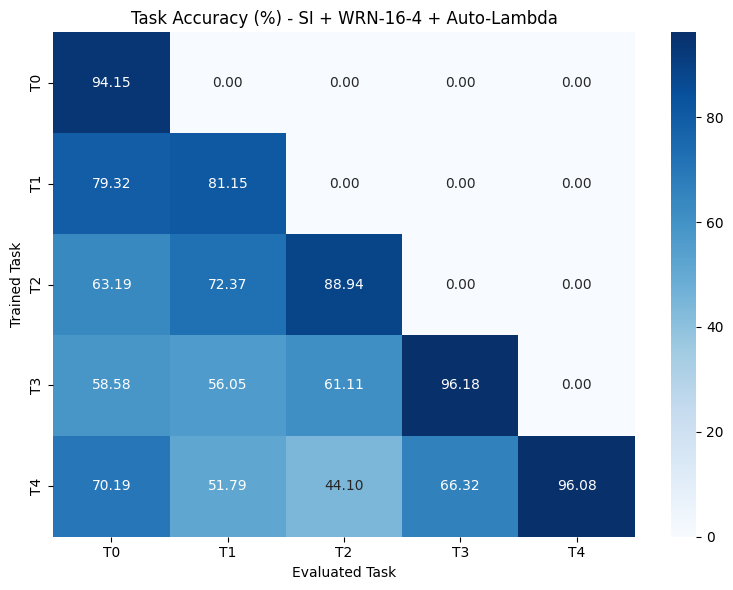

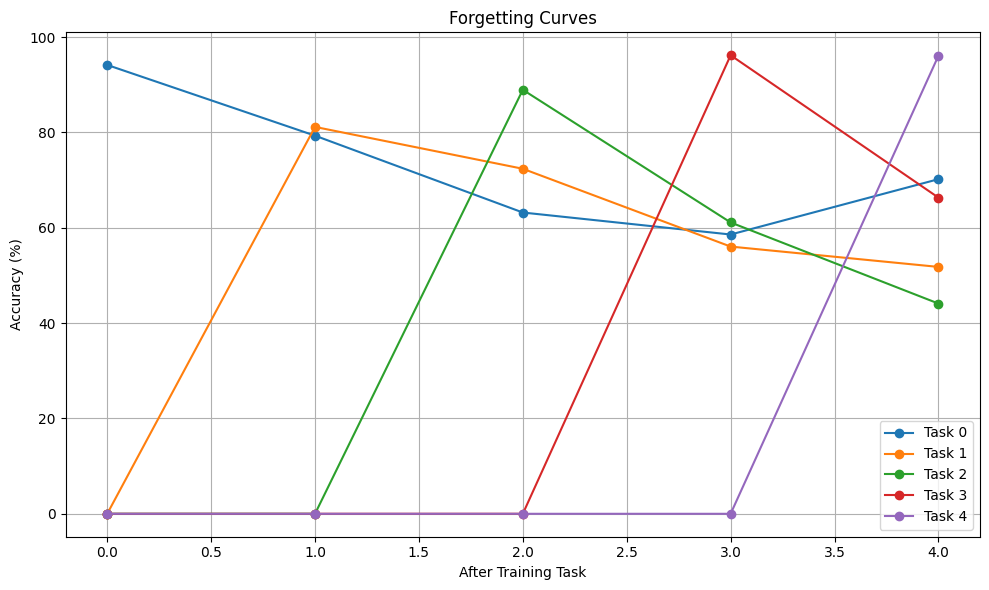

In [2]:
# SI on Split CIFAR-10
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns

# WRN-16-4
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = None if self.equalInOut else nn.Conv2d(in_planes, out_planes, 1, stride, 0, bias=False)

    def forward(self, x):
        out = self.relu1(self.bn1(x)) if self.equalInOut else self.relu1(self.bn1(x))
        shortcut = x if self.equalInOut else self.convShortcut(x)
        out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        out = self.conv2(out)
        return out + shortcut

class NetworkBlock(nn.Module):
    def __init__(self, n, in_planes, out_planes, block, stride):
        super().__init__()
        self.layer = nn.Sequential(*[block(in_planes if i == 0 else out_planes,
                                           out_planes, stride if i == 0 else 1) for i in range(n)])

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=10):
        super().__init__()
        assert (depth - 4) % 6 == 0
        n = (depth - 4) // 6
        k = widen_factor
        nChannels = [16, 16*k, 32*k, 64*k]
        self.conv1 = nn.Conv2d(3, nChannels[0], 3, 1, 1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], BasicBlock, 1)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], BasicBlock, 2)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], BasicBlock, 2)
        self.bn = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, 1).view(-1, self.nChannels)
        return self.fc(x)

# Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Config
base_lambda = 15.0
n_epochs = 2
batch_size = 32
lr = 0.001 
tasks = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]

# Data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

def get_task_dataset(dataset, class_list):
    idx = [i for i, (_, y) in enumerate(dataset) if y in class_list]
    return Subset(dataset, idx)

# SI Functions
def update_omega(omega, model, dataloader):
    grads = {n: torch.zeros_like(p) for n, p in model.named_parameters() if p.requires_grad}
    model.eval()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        for n, p in model.named_parameters():
            if p.grad is not None:
                grads[n] += p.grad.detach() ** 2
    for n in grads:
        omega[n] += grads[n] / len(dataloader)
    return omega

def si_loss(model, prev_params, omega):
    loss = 0.0
    for n, p in model.named_parameters():
        if n in prev_params:
            delta = p - prev_params[n]
            loss += (omega[n].detach() * delta.pow(2)).sum()
    return loss

def masked_cross_entropy(logits, labels, class_list):
    class_mask = torch.tensor(class_list, device=logits.device)
    class_idx = {c: i for i, c in enumerate(class_list)}
    filtered_logits = logits[:, class_mask]
    new_labels = torch.tensor([class_idx[l.item()] for l in labels], device=labels.device)
    return F.cross_entropy(filtered_logits, new_labels)

def masked_accuracy(logits, labels, class_list):
    class_mask = torch.tensor(class_list, device=logits.device)
    filtered_logits = logits[:, class_mask]
    preds = filtered_logits.argmax(dim=1)
    idx_map = {c: i for i, c in enumerate(class_list)}
    true = torch.tensor([idx_map[l.item()] for l in labels], device=labels.device)
    return (preds == true).float().mean().item() * 100

# Init
model = WideResNet(depth=28, widen_factor=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
omega = {n: torch.zeros_like(p, device=device) for n, p in model.named_parameters() if p.requires_grad}
prev_params = {}
acc_matrix = np.zeros((len(tasks), len(tasks)))
test_loaders = []

# Training loop
for t, class_pair in enumerate(tasks):
    print(f"\n=== Task {t} - Classes {class_pair} ===")
    train_data = get_task_dataset(train_dataset, class_pair)
    test_data = get_task_dataset(test_dataset, class_pair)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    test_loaders.append((test_loader, class_pair))

    for epoch in range(n_epochs):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            ce_loss = masked_cross_entropy(logits, y, class_pair)

            if t > 0:
                si_reg = si_loss(model, prev_params, omega)
                si_lambda = (ce_loss.item() / (si_reg.item() + 1e-8)) * base_lambda
                si_lambda = min(si_lambda, 100.0)
                total_loss = ce_loss + si_lambda * si_reg

                # Debug prints
                if step % 20 == 0:
                    print(f"[Task {t} | Epoch {epoch}] CE: {ce_loss.item():.4f} | SI: {si_reg.item():.4f} | λ: {si_lambda:.2f}")
            else:
                total_loss = ce_loss

            total_loss.backward()
            optimizer.step()

    omega = update_omega(omega, model, train_loader)
    prev_params = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}

    # Evaluation
    for prev_t, (loader, class_pair_eval) in enumerate(test_loaders):
        model.eval()
        accs = []
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                acc = masked_accuracy(logits, y, class_pair_eval)
                accs.append(acc)
            acc_matrix[t][prev_t] = np.mean(accs)
            print(f"Eval on Task {prev_t} after Task {t}: {acc_matrix[t][prev_t]:.2f}%")

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"T{i}" for i in range(len(tasks))],
            yticklabels=[f"T{i}" for i in range(len(tasks))])
plt.xlabel("Evaluated Task")
plt.ylabel("Trained Task")
plt.title("Task Accuracy (%) - SI + WRN-28-10 + Auto-Lambda")
plt.tight_layout()
plt.show()

# Forgetting Curve
plt.figure(figsize=(10, 6))
for task_id in range(len(tasks)):
    plt.plot(acc_matrix[:, task_id], marker='o', label=f'Task {task_id}')
plt.xlabel("After Training Task")
plt.ylabel("Accuracy (%)")
plt.title("Forgetting Curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Using: cuda
Files already downloaded and verified
Files already downloaded and verified

=== Task 0 - Classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ===
Eval on Task 0 after Task 0: 47.07%

=== Task 1 - Classes [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] ===
[Task 1 | Epoch 0] CE: 2.3610 | SI: 0.0000 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.9352 | SI: 0.0000 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.8849 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.3585 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.6771 | SI: 0.0001 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.6858 | SI: 0.0002 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.3549 | SI: 0.0005 | λ: 100.00
[Task 1 | Epoch 0] CE: 1.5798 | SI: 0.0003 | λ: 100.00
[Task 1 | Epoch 1] CE: 1.4347 | SI: 0.0004 | λ: 100.00
[Task 1 | Epoch 1] CE: 1.5362 | SI: 0.0004 | λ: 100.00
[Task 1 | Epoch 1] CE: 1.3979 | SI: 0.0004 | λ: 100.00
[Task 1 | Epoch 1] CE: 1.3658 | SI: 0.0006 | λ: 100.00
[Task 1 | Epoch 1] CE: 1.0996 | SI: 0.0005 | λ: 100.00
[Task 1 | Epoch 1] CE: 1.6206 | SI: 0

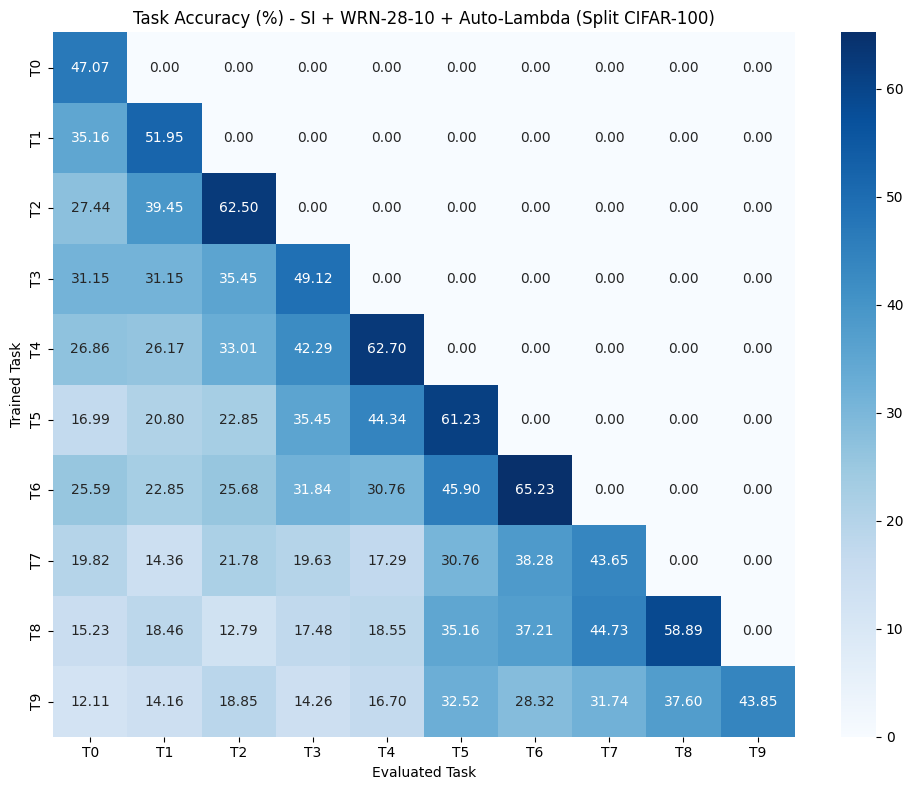

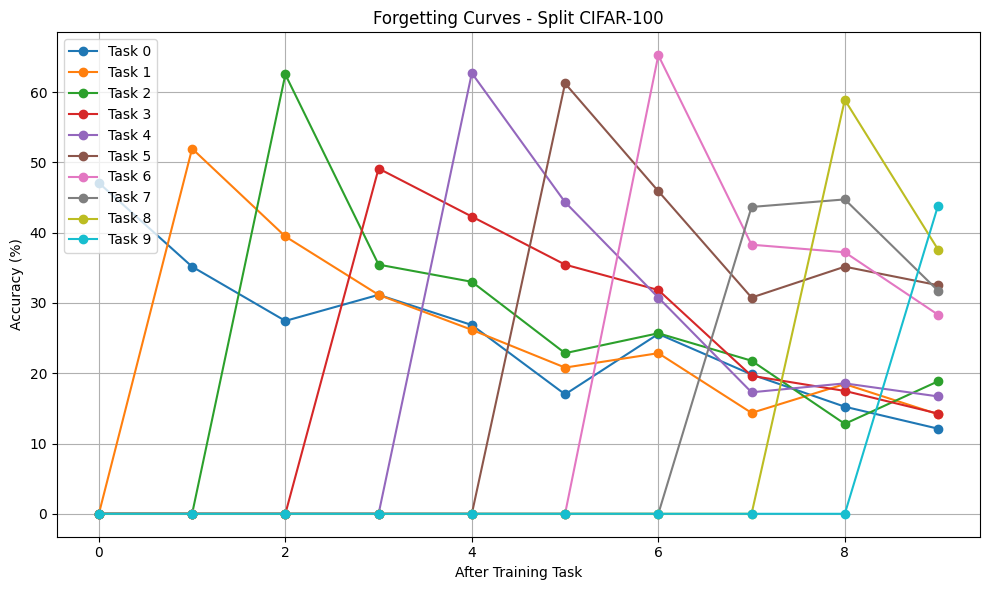

In [3]:
# SI on Split CIFAR-100
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns

# WRN-16-4
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = None if self.equalInOut else nn.Conv2d(in_planes, out_planes, 1, stride, 0, bias=False)

    def forward(self, x):
        out = self.relu1(self.bn1(x)) if self.equalInOut else self.relu1(self.bn1(x))
        shortcut = x if self.equalInOut else self.convShortcut(x)
        out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        out = self.conv2(out)
        return out + shortcut

class NetworkBlock(nn.Module):
    def __init__(self, n, in_planes, out_planes, block, stride):
        super().__init__()
        self.layer = nn.Sequential(*[block(in_planes if i == 0 else out_planes,
                                           out_planes, stride if i == 0 else 1) for i in range(n)])

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=100):
        super().__init__()
        assert (depth - 4) % 6 == 0
        n = (depth - 4) // 6
        k = widen_factor
        nChannels = [16, 16*k, 32*k, 64*k]
        self.conv1 = nn.Conv2d(3, nChannels[0], 3, 1, 1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], BasicBlock, 1)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], BasicBlock, 2)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], BasicBlock, 2)
        self.bn = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, 1).view(-1, self.nChannels)
        return self.fc(x)

# Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Config
base_lambda = 15.0
n_epochs = 2
batch_size = 32
lr = 0.001
tasks = [list(range(i*10, (i+1)*10)) for i in range(10)]  # 10 tasks × 10 classes

# Data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

def get_task_dataset(dataset, class_list):
    idx = [i for i, (_, y) in enumerate(dataset) if y in class_list]
    return Subset(dataset, idx)

# SI Functions
def update_omega(omega, model, dataloader):
    grads = {n: torch.zeros_like(p) for n, p in model.named_parameters() if p.requires_grad}
    model.eval()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        for n, p in model.named_parameters():
            if p.grad is not None:
                grads[n] += p.grad.detach() ** 2
    for n in grads:
        omega[n] += grads[n] / len(dataloader)
    return omega

def si_loss(model, prev_params, omega):
    loss = 0.0
    for n, p in model.named_parameters():
        if n in prev_params:
            delta = p - prev_params[n]
            loss += (omega[n].detach() * delta.pow(2)).sum()
    return loss

def masked_cross_entropy(logits, labels, class_list):
    class_mask = torch.tensor(class_list, device=logits.device)
    class_idx = {c: i for i, c in enumerate(class_list)}
    filtered_logits = logits[:, class_mask]
    new_labels = torch.tensor([class_idx[l.item()] for l in labels], device=labels.device)
    return F.cross_entropy(filtered_logits, new_labels)

def masked_accuracy(logits, labels, class_list):
    class_mask = torch.tensor(class_list, device=logits.device)
    filtered_logits = logits[:, class_mask]
    preds = filtered_logits.argmax(dim=1)
    idx_map = {c: i for i, c in enumerate(class_list)}
    true = torch.tensor([idx_map[l.item()] for l in labels], device=labels.device)
    return (preds == true).float().mean().item() * 100

# Init
model = WideResNet(depth=28, widen_factor=10, num_classes=100).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
omega = {n: torch.zeros_like(p, device=device) for n, p in model.named_parameters() if p.requires_grad}
prev_params = {}
acc_matrix = np.zeros((len(tasks), len(tasks)))
test_loaders = []

# Training loop
for t, class_group in enumerate(tasks):
    print(f"\n=== Task {t} - Classes {class_group} ===")
    train_data = get_task_dataset(train_dataset, class_group)
    test_data = get_task_dataset(test_dataset, class_group)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    test_loaders.append((test_loader, class_group))

    for epoch in range(n_epochs):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            ce_loss = masked_cross_entropy(logits, y, class_group)

            if t > 0:
                si_reg = si_loss(model, prev_params, omega)
                si_lambda = (ce_loss.item() / (si_reg.item() + 1e-8)) * base_lambda
                si_lambda = min(si_lambda, 100.0)
                total_loss = ce_loss + si_lambda * si_reg

                if step % 20 == 0:
                    print(f"[Task {t} | Epoch {epoch}] CE: {ce_loss.item():.4f} | SI: {si_reg.item():.4f} | λ: {si_lambda:.2f}")
            else:
                total_loss = ce_loss

            total_loss.backward()
            optimizer.step()

    omega = update_omega(omega, model, train_loader)
    prev_params = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}

    # Evaluation
    for prev_t, (loader, class_group_eval) in enumerate(test_loaders):
        model.eval()
        accs = []
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                acc = masked_accuracy(logits, y, class_group_eval)
                accs.append(acc)
            acc_matrix[t][prev_t] = np.mean(accs)
            print(f"Eval on Task {prev_t} after Task {t}: {acc_matrix[t][prev_t]:.2f}%")

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"T{i}" for i in range(len(tasks))],
            yticklabels=[f"T{i}" for i in range(len(tasks))])
plt.xlabel("Evaluated Task")
plt.ylabel("Trained Task")
plt.title("Task Accuracy (%) - SI + WRN-28-10 + Auto-Lambda (Split CIFAR-100)")
plt.tight_layout()
plt.show()

# Forgetting Curves
plt.figure(figsize=(10, 6))
for task_id in range(len(tasks)):
    plt.plot(acc_matrix[:, task_id], marker='o', label=f'Task {task_id}')
plt.xlabel("After Training Task")
plt.ylabel("Accuracy (%)")
plt.title("Forgetting Curves - Split CIFAR-100")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()